<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*The Vaidman Detection Test: Interaction Free Measurement*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
S. Alex Breitweiser

## Introduction

One surprising result of quantum mechanics is the ability to measure something without ever directly "observing" it. This interaction-free measurement cannot be reproduced in classical mechanics. The prototypical example is the [Elitzur–Vaidman Bomb Experiment](https://en.wikipedia.org/wiki/Elitzur%E2%80%93Vaidman_bomb_tester) - in which one wants to test whether bombs are active without detonating them. In this example we will test whether an unknown operation is null (the identity) or an X gate, corresponding to a dud or a live bomb.

### The Algorithm
The algorithm will use two qubits, $q_1$ and $q_2$, as well as a small parameter, $\epsilon = \frac{\pi}{n}$ for some integer $n$. Call the unknown gate, which is either the identity or an X gate, $G$, and assume we have it in a controlled form. The algorithm is then:
1. Start with both $q_1$ and $q_2$ in the $|0\rangle$ state
2. Rotate $q_1$ by $\epsilon$ about the Y axis
3. Apply a controlled $G$ on $q_2$, conditioned on $q_1$
4. Measure $q_2$
5. Repeat (2-4) $n$ times
6. Measure $q_1$

![Algorithm Depiction](http://i.imgur.com/sG8Pa3J.jpg)

### Explanation and proof of correctness
There are two cases: Either the gate is the identity (a dud), or it is an X gate (a live bomb).
#### Case 1: Dud
After rotation, $q_1$ is now approximately
$$q_1 \approx |0\rangle + \epsilon |1\rangle$$
Since the unknown gate is the identity, the controlled gate leaves the two qubit state separable,
$$q_1 \times q_2 \approx (|0\rangle + \epsilon |1\rangle) \times |0\rangle$$
and measurement is trivial (we will always measure $|0\rangle$ for $q_2$).
Repetition will not change this result - we will always keep separability and $q_2$ will remain in $|0\rangle$.
After n steps, $q_1$ will flip by $\pi$ to $|1\rangle$, and so measuring it will certainly yield $1$. Therefore, the output register for a dud bomb will read:
$$000...01$$
#### Case 2: Live
Again, after rotation, $q_1$ is now approximately
$$q_1 \approx |0\rangle + \epsilon |1\rangle$$
But, since the unknown gate is now an X gate, the combined state after $G$ is now
$$q_1 \times q_2 \approx |00\rangle + \epsilon |11\rangle$$
Measuring $q_2$ now might yield $1$, in which case we have "measured" the live bomb (obtained a result which differs from that of a dud) and it explodes. However, this only happens with probability $\epsilon^2$. In the vast majority of cases, we will measure $0$ and the entire system will collapse back to
$$q_1 \times q_2 = |00\rangle$$
After every step, the system will most likely return to the original state, and the final measurement of $q_1$ will yield $0$. Therefore, the most likely outcome of a live bomb is
$$000...00$$
which will identify a live bomb without ever "measuring" it. If we ever obtain a 1 in the bits preceding the final bit, we will have detonated the bomb, but this will only happen with probability roughly
$$P \propto n \epsilon^2 \propto \epsilon$$
This probability may be made arbitrarily small at the cost of an arbitrarily long circuit.

## Generating Random Bombs
A test set must be generated to experiment on - this can be done by classical (pseudo)random number generation, but as long as we have access to a quantum computer we might as well take advantage of the ability to generate true randomness.

In [7]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception('Please use Python version 3 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter #Use this to convert results from list to dict for histogram


import sys
sys.path.append('../../../qiskit-sdk-py/')
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

We will generate a test set of 50 "bombs", and each "bomb" will be run through a 20-step measurement circuit. We set up the program as explained in previous examples.

In [8]:
device = 'ibmqx2' # the device to run on
device = 'local_qasm_simulator' # uncomment to run on the simulator
N = 50 # Number of bombs
steps = 20 # Number of steps for the algorithm, limited by maximum circuit depth
eps = np.pi / steps # Algorithm parameter, small

QPS_SPECS = {
    "name": "IFM",
    "circuits": [{
        "name": "IFM_gen", # Prototype circuit for bomb generation
        "quantum_registers": [{
            "name":"q_gen",
            "size":1
        }],
        "classical_registers": [{
            "name":"c_gen",
            "size":1
        }]},
        {"name": "IFM_meas", # Prototype circuit for bomb measurement
        "quantum_registers": [{
            "name":"q",
            "size":2
        }],
        "classical_registers": [{
            "name":"c",
            "size":steps+1
        }]}]
}

Q_program = QuantumProgram(specs=QPS_SPECS)
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])

Generating a random bomb is achieved by simply applying a Hadamard gate to a $q_1$, which starts in $|0\rangle$, and then measuring. This randomly gives a $0$ or $1$, each with equal probability. We run one such circuit for each bomb, since circuits are currently limited to a single measurement.

In [9]:
# Quantum circuits to generate bombs
circuits = ["IFM_gen"+str(i) for i in range(N)]
# NB: Can't have more than one measurement per circuit
for circuit in circuits:
    q_gen = Q_program.get_quantum_register("q_gen")
    c_gen = Q_program.get_classical_register('c_gen')
    IFM = Q_program.create_circuit(circuit, [q_gen], [c_gen])
    IFM.h(q_gen[0]) #Turn the qubit into |0> + |1>
    IFM.measure(q_gen[0], c_gen[0])
_ = Q_program.get_qasms(circuits) # Suppress the output

Note that, since we want to measure several discrete instances, we do *not* want to average over multiple shots. Averaging would yield partial bombs, but we assume bombs are discretely either live or dead.

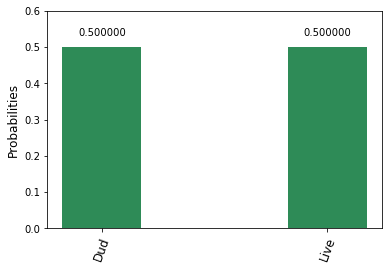

In [10]:
result = Q_program.execute(circuits, device, shots=1, max_credits=5, wait=10, timeout=240) # Note that we only want one shot
bombs = []
for circuit in circuits:
    for key in result.get_counts(circuit): # Hack, there should only be one key, since there was only one shot
        bombs.append(int(key))
#print(', '.join(('Live' if bomb else 'Dud' for bomb in bombs))) # Uncomment to print out "truth" of bombs
plot_histogram(Counter(('Live' if bomb else 'Dud' for bomb in bombs))) #Plotting bomb generation results

## Testing the Bombs

Here we implement the algorithm described above to measure the bombs. As with the generation of the bombs, it is currently impossible to take several measurements in a single circuit - therefore, it must be run on the simulator.

In [11]:
device = 'local_qasm_simulator' #Running on the simulator
circuits = ["IFM_meas"+str(i) for i in range(N)]
#Creating one measurement circuit for each bomb
for i in range(N):
    bomb = bombs[i]
    q = Q_program.get_quantum_register("q")
    c = Q_program.get_classical_register('c')
    IFM = Q_program.create_circuit(circuits[i], [q], [c])
    for step in range(steps):
        IFM.ry(eps, q[0]) #First we rotate the control qubit by epsilon
        if bomb: #If the bomb is live, the gate is a controlled X gate
            IFM.cx(q[0],q[1])
        #If the bomb is a dud, the gate is a controlled identity gate, which does nothing
        IFM.measure(q[1], c[step]) #Now we measure to collapse the combined state
    IFM.measure(q[0], c[steps])
Q_program.get_qasms(circuits)
result = Q_program.execute(circuits, device, shots=1, max_credits=5, wait=10, timeout=240)


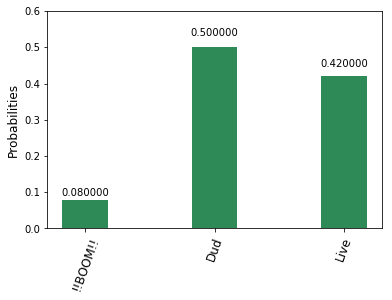

In [12]:
def get_status(counts):
    # Return whether a bomb was a dud, was live but detonated, or was live and undetonated
    # Note that registers are returned in reversed order
    for key in counts:
        if '1' in key[1:]:
             #If we ever measure a '1' from the measurement qubit (q1), the bomb was measured and will detonate
            return '!!BOOM!!'
        elif key[0] == '1':
            #If the control qubit (q0) was rotated to '1', the state never entangled because the bomb was a dud
            return 'Dud'
        else:
            #If we only measured '0' for both the control and measurement qubit, the bomb was live but never set off
            return 'Live'


results = {'Live': 0, 'Dud': 0, "!!BOOM!!": 0}
for circuit in circuits:
    status = get_status(result.get_counts(circuit))
    results[status] += 1
plot_histogram(results)